In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bapsflib import lapd
from bapsfda.processing import get_board_props, SISRun
from bapsfda.diagnostics import LangmuirSweep
from bapsfda.diagnostics._interferometer import Interferometer
from bapsfda.processing import sav_smooth, butt_low
from bapsfda.processing import sgaussian_half, expfit
from bapsfda.visualization import plot_3d_surf
from scipy.optimize import curve_fit
from astropy.constants import e, m_p
import pprint
import astropy.units as u
import os

In [2]:
data_path = "./july2023/"
file_dict = {s[:2]: s for s in os.listdir(data_path)}
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(file_dict)

{   '06': '06_xline_sweep_p20_3srep_125Vps_105Vpuff.hdf5',
    '07': '07_xline_sweep_p32_3srep_125Vps_105Vpuff.hdf5',
    '08': '08_xline_sweep_p43_3srep_125Vps_105Vpuff.hdf5',
    '09': '09_mach_cal_180_p20_3srep_125Vps_105Vpuff.hdf5',
    '10': '10_mach_cal_0_p20_3srep_125Vps_105Vpuff.hdf5',
    '11': '11_xline_mach_p20_3srep_125Vps_105Vpuff.hdf5',
    '12': '12_xline_mach_p20_3srep_125Vps_75Vpuff.hdf5',
    '13': '13_xline_sweep_p43_3srep_125Vps_75Vpuff.hdf5',
    '14': '14_xline_sweep_p32_3srep_125Vps_75Vpuff.hdf5',
    '15': '15_xline_sweep_p20_3srep_125Vps_75Vpuff.hdf5',
    '16': '16_xline_sweep_p20_3srep_125Vps_90Vpuff.hdf5',
    '17': '17_xline_sweep_p32_3srep_125Vps_90Vpuff.hdf5',
    '18': '18_xline_sweep_p43_3srep_125Vps_90Vpuff.hdf5',
    '19': '19_mach_cal_180_p20_3srep_125Vps_90Vpuff.hdf5',
    '20': '20_mach_cal_0_p20_3srep_125Vps_90Vpuff.hdf5',
    '21': '21_xline_mach_p20_3srep_125Vps_90Vpuff.hdf5',
    '22': '22_xline_Emissive_p38_3srep_125Vps_105Vpuff.hdf5',
    '23

In [3]:
run_num = "09"
run_name = f"{data_path}{file_dict[run_num]}"

In [4]:
with lapd.File(run_name) as f:
    f.run_description()

Calibration run for mach probe using Unlucky #3 on port 20 rotated upside down. 10 Shots at (0,0)

LAPD B field:
Black magnets at south: 760 A (PS12, 13),
Yellow & Purple magnets: configured for uniform 1.5 kG
Black magnets at north: 0 A (PS11)

South LaB6 source:
He plasma , discharge PS voltage/current: 12V/7100A Control Room
84-70 V cathode-anode voltage, 1/3 Hz rep rate 
Heater: 2006A
Gas Puff (105 V on East and West, 26ms) Helium
Minimum background pressure on pfieffer box (4.5e-5, 5.6e-5)

Timing:
=====
Discharge Peried: 20 ms
Breakdown time: 6 ms
Sweep: Starting 0 ms, 96us ramp up, 28 cycles, 1ms pause
DAQ trigger: 0 ms  

Risat25= 9 Ohm  Bias: -100 V w.r.t. chamber ground 
Rsweep25= 1 Ohm 
Risat31 = 330 Ohm
Reference chamber ground

Channels:
Board 1: 
Chan8: VAnode, G=1/40
Board 4:
All Channels, Isat, R=7.5
Chan5: (UL3-LT) G = 0.88
Chan6: (UL3-LB) G = 1.08
Chan7: (UL3-RT) G = 0.86
Chan8: (UL3-RB) G = 0.94


In [5]:
run_num = "09"
run_name = f"{data_path}{file_dict[run_num]}"
run = SISRun(run_name)
run.config_drive("fixed", run.num_shots, 1, 1, 1)
# run.config_drive("xline", 10, nx = 61)
run.rename_channel("b1_c8", "V_anode")
run.rename_channel("b4_c5", "LT")
run.rename_channel("b4_c6", "LB")
run.rename_channel("b4_c7", "RT")
run.rename_channel("b4_c8", "RB")
run.set_drive_props("V_anode", "fixed")
run.set_drive_props("LT", "fixed")
run.set_drive_props("LB", "fixed")
run.set_drive_props("RT", "fixed")
run.set_drive_props("RB", "fixed")
run.set_chan_props("V_anode", gain = 1/40)
run.set_chan_props("LT", gain = 0.88, resistance = 7.5)
run.set_chan_props("LB", gain = 1.08, resistance = 7.5) 
run.set_chan_props("RT", gain = 0.86, resistance = 7.5)
run.set_chan_props("RB", gain = 0.94, resistance = 7.5)
t_array = run.board_props["board_4"].time_array
tips = ["LT", "LB", "RT", "RB"]
dt = run.extract_signal("LT").dt
isat_mach = np.empty((4, 10, 249856))
for i, tip in enumerate(tips):
    isat_mach[i] = run.extract_signal(tip)
isat_mach = np.mean(isat_mach, axis = 1)
isat_mach = np.moveaxis(np.moveaxis(isat_mach, 0, 1) - np.mean(isat_mach[:,-2000:], axis=-1),0,1)
freq = (1/dt).to(u.Hz).value
isat_mach = butt_low(isat_mach, 10e3, freq)
isat_mach_smooth = sav_smooth(isat_mach, b = 60, axis=-1)
front1 = np.mean(isat_mach_smooth[0:2], axis = 0)
back1 = np.mean(isat_mach_smooth[2:], axis = 0)

{'clock rate': <Quantity 100. MHz>, 'shot average (software)': None, 'sample average (hardware)': 64, 'bit': 16, 'nshotnum': 10, 'nt': 75776}
{'clock rate': <Quantity 100. MHz>, 'shot average (software)': None, 'sample average (hardware)': 16, 'bit': 16, 'nshotnum': 10, 'nt': 249856}


In [6]:
run_num = "10"
run_name = f"{data_path}{file_dict[run_num]}"
run = SISRun(run_name)
run.config_drive("fixed", run.num_shots, 1, 1, 1)
# run.config_drive("xline", 10, nx = 61)
run.rename_channel("b1_c8", "V_anode")
run.rename_channel("b4_c5", "LT")
run.rename_channel("b4_c6", "LB")
run.rename_channel("b4_c7", "RT")
run.rename_channel("b4_c8", "RB")
run.set_drive_props("V_anode", "fixed")
run.set_drive_props("LT", "fixed")
run.set_drive_props("LB", "fixed")
run.set_drive_props("RT", "fixed")
run.set_drive_props("RB", "fixed")
run.set_chan_props("V_anode", gain = 1/40)
run.set_chan_props("LT", gain = 0.88, resistance = 7.5)
run.set_chan_props("LB", gain = 1.08, resistance = 7.5) 
run.set_chan_props("RT", gain = 0.86, resistance = 7.5)
run.set_chan_props("RB", gain = 0.94, resistance = 7.5)
t_array = run.board_props["board_4"].time_array
tips = ["LT", "LB", "RT", "RB"]
dt = run.extract_signal("LT").dt
isat_mach = np.empty((4, 10, 249856))
for i, tip in enumerate(tips):
    isat_mach[i] = run.extract_signal(tip)
isat_mach = np.mean(isat_mach, axis = 1)
isat_mach = np.moveaxis(np.moveaxis(isat_mach, 0, 1) - np.mean(isat_mach[:,-2000:], axis=-1),0,1)
freq = (1/dt).to(u.Hz).value
isat_mach = butt_low(isat_mach, 10e3, freq)
isat_mach_smooth = sav_smooth(isat_mach, b = 60, axis=-1)
front2 = np.mean(isat_mach_smooth[0:2], axis = 0)
back2 = np.mean(isat_mach_smooth[2:], axis = 0)

{'clock rate': <Quantity 100. MHz>, 'shot average (software)': None, 'sample average (hardware)': 64, 'bit': 16, 'nshotnum': 10, 'nt': 75776}
{'clock rate': <Quantity 100. MHz>, 'shot average (software)': None, 'sample average (hardware)': 16, 'bit': 16, 'nshotnum': 10, 'nt': 249856}


In [7]:
test1 = front1/back2
test2 = back1/front2

In [8]:
test2.shape

(249856,)

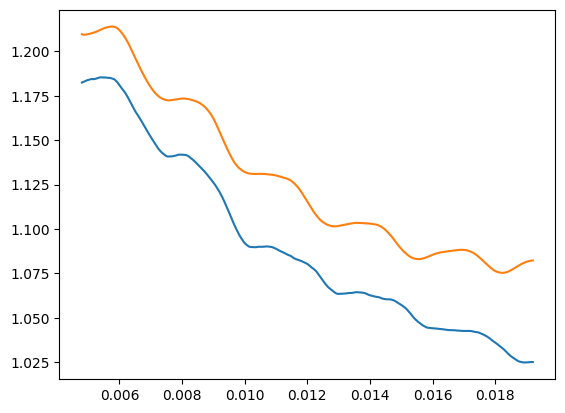

In [9]:
sliceobj = slice(30000,120000)
plt.plot(t_array[sliceobj],test1[sliceobj])
plt.plot(t_array[sliceobj],test2[sliceobj])

In [10]:
a = np.mean(test1[sliceobj])
b = np.mean(test2[sliceobj])
c = np.mean([a,b]) # multiply c to backside average to normalize areas
print(a,b,c)

1.0912458369074838 1.1285740758561067 1.1099099563817951


In [11]:
isat_mach_smooth[-3:-1].shape

(2, 249856)

{'clock rate': <Quantity 100. MHz>, 'shot average (software)': None, 'sample average (hardware)': 64, 'bit': 16, 'nshotnum': 610, 'nt': 75776}
{'clock rate': <Quantity 100. MHz>, 'shot average (software)': None, 'sample average (hardware)': 16, 'bit': 16, 'nshotnum': 610, 'nt': 249856}


C:\Users\trloo\AppData\Local\Temp\ipykernel_29952\18066026.py:34: RuntimeWarning: invalid value encountered in log
  mach_num = np.mean(np.log(mach_front/mach_back).reshape(61,10,249856), axis = 1)/1.66


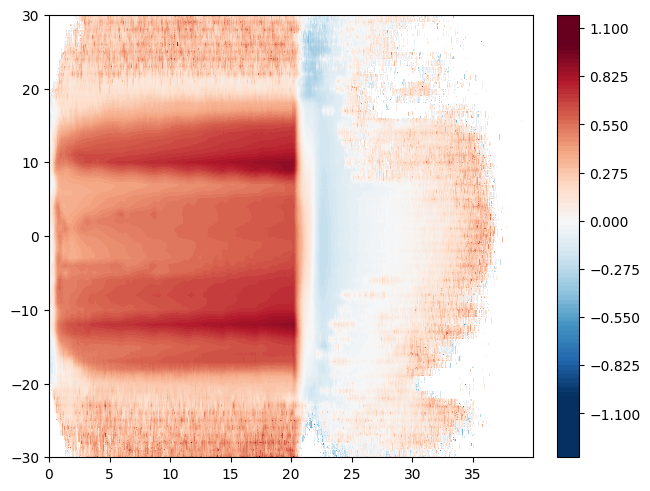

In [18]:
run_num = "11"
puff = "105"
run_name = f"{data_path}{file_dict[run_num]}"
run = SISRun(run_name)
run.config_drive("fixed", run.num_shots, 1, 1, 1)
run.config_drive("xline", 10, nx = 61)
run.rename_channel("b1_c8", "V_anode")
run.rename_channel("b4_c5", "LT")
run.rename_channel("b4_c6", "LB")
run.rename_channel("b4_c7", "RT")
run.rename_channel("b4_c8", "RB")
run.set_drive_props("V_anode", "fixed")
run.set_drive_props("LT", "xline")
run.set_drive_props("LB", "xline")
run.set_drive_props("RT", "xline")
run.set_drive_props("RB", "xline")
run.set_chan_props("V_anode", gain = 1/40)
run.set_chan_props("LT", gain = 0.88, resistance = 7.5)
run.set_chan_props("LB", gain = 1.08, resistance = 7.5) 
run.set_chan_props("RT", gain = 0.86, resistance = 7.5)
run.set_chan_props("RB", gain = 0.94, resistance = 7.5)
t_array = run.board_props["board_4"].time_array
tips = ["LT", "LB", "RT", "RB"]
dt = run.extract_signal("LT").dt
isat_mach = np.empty((4, 610, 249856))
for i, tip in enumerate(tips):
    isat_mach[i] = run.extract_signal(tip)
    isat_mach[i] = np.moveaxis(np.moveaxis(isat_mach[i], 0, 1) - np.mean(isat_mach[i,:,-2000:], axis=-1),0,1)
freq = (1/dt).to(u.Hz).value
# isat_mach = butt_low(isat_mach, 10e3, freq)
# isat_mach_smooth = sav_smooth(isat_mach, b = 60, axis=-1)
mach_front = np.mean(isat_mach[0:2], axis = 0)
mach_back = c*np.mean(isat_mach[2:], axis = 0)
mach_num = np.mean(np.log(mach_front/mach_back).reshape(61,10,249856), axis = 1)/1.66
Y  = (np.arange(61)-30)
X = t_array*1e3
Z = mach_num
fig, ax = plt.subplots(layout = "constrained")
CS = ax.contourf(X, Y, Z, 101, cmap = "RdBu_r", vmin=-1, vmax=1)
cbar = fig.colorbar(CS)
fig.savefig(f"./analysisj23/plots/mach_p20_{puff}V_contour.pdf")
np.savez(f"./analysisj23/mach_p20_{puff}V.npz", time_ms = X, x_pos = Y, mach_num = Z)

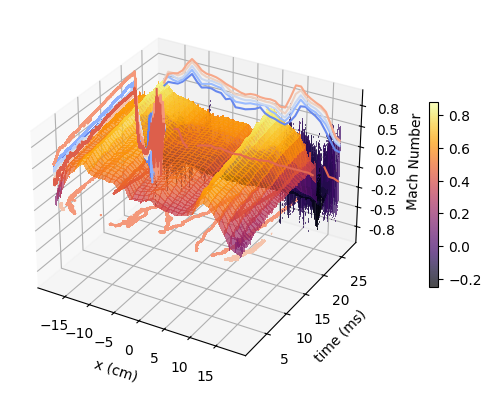

In [46]:
# sliceobj = slice(10000,170000)
# sliceobj2 = slice(12,49)
# puff = "105"
# port = "20"
# x_label = "x (cm)"
# y_label = "time (ms)"
# z_label = "Mach Number"
# X  = (np.arange(61)-30)[sliceobj2]
# Y = t_array[sliceobj]*1e3
# Z = uncal_mach.transpose()[sliceobj,sliceobj2]/1.66
# plt_fname = f"./analysisj23/plots/port{port}_mach_{puff}puff_125ps.pdf"
# plot_3d_surf(X, Y, Z, file_name = plt_fname, xlabel = x_label, ylabel = y_label, zlabel = z_label, contour = True)

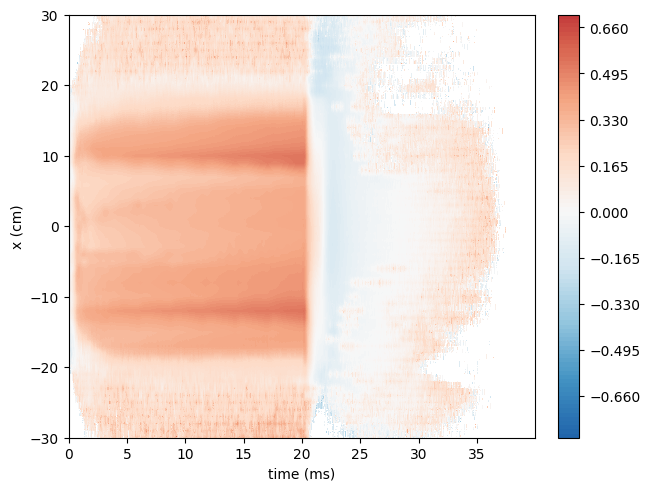

In [17]:
Y  = (np.arange(61)-30)
X = t_array*1e3
Z = mach_num
fig, ax = plt.subplots(layout = "constrained")
CS = ax.contourf(X, Y, Z, 101, cmap = "RdBu_r", vmin=-1, vmax=1)
cbar = fig.colorbar(CS)
ax.set_xlabel("time (ms)")
ax.set_ylabel("x (cm)")
fig.savefig(f"./analysisj23/plots/mach_p20_105V_contour.pdf")
np.savez("./analysisj23/mach_p20_105v.npz", time_ms = X, x_pos = Y, mach_num = Z)

{'clock rate': <Quantity 100. MHz>, 'shot average (software)': None, 'sample average (hardware)': 64, 'bit': 16, 'nshotnum': 610, 'nt': 75776}
{'clock rate': <Quantity 100. MHz>, 'shot average (software)': None, 'sample average (hardware)': 16, 'bit': 16, 'nshotnum': 610, 'nt': 249856}


C:\Users\trloo\AppData\Local\Temp\ipykernel_29952\2722638625.py:34: RuntimeWarning: invalid value encountered in log
  mach_num = np.mean(np.log(mach_front/mach_back).reshape(61,10,249856), axis = 1)/1.66


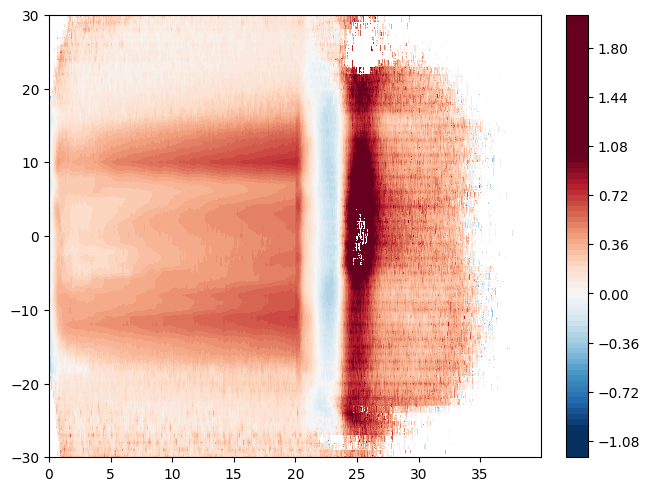

In [19]:
run_num = "12"
puff = "75"
run_name = f"{data_path}{file_dict[run_num]}"
run = SISRun(run_name)
run.config_drive("fixed", run.num_shots, 1, 1, 1)
run.config_drive("xline", 10, nx = 61)
run.rename_channel("b1_c8", "V_anode")
run.rename_channel("b4_c5", "LT")
run.rename_channel("b4_c6", "LB")
run.rename_channel("b4_c7", "RT")
run.rename_channel("b4_c8", "RB")
run.set_drive_props("V_anode", "fixed")
run.set_drive_props("LT", "xline")
run.set_drive_props("LB", "xline")
run.set_drive_props("RT", "xline")
run.set_drive_props("RB", "xline")
run.set_chan_props("V_anode", gain = 1/40)
run.set_chan_props("LT", gain = 0.88, resistance = 7.5)
run.set_chan_props("LB", gain = 1.08, resistance = 7.5) 
run.set_chan_props("RT", gain = 0.86, resistance = 7.5)
run.set_chan_props("RB", gain = 0.94, resistance = 7.5)
t_array = run.board_props["board_4"].time_array
tips = ["LT", "LB", "RT", "RB"]
dt = run.extract_signal("LT").dt
isat_mach = np.empty((4, 610, 249856))
for i, tip in enumerate(tips):
    isat_mach[i] = run.extract_signal(tip)
    isat_mach[i] = np.moveaxis(np.moveaxis(isat_mach[i], 0, 1) - np.mean(isat_mach[i,:,-2000:], axis=-1),0,1)
freq = (1/dt).to(u.Hz).value
# isat_mach = butt_low(isat_mach, 10e3, freq)
# isat_mach_smooth = sav_smooth(isat_mach, b = 60, axis=-1)
mach_front = np.mean(isat_mach[0:2], axis = 0)
mach_back = c*np.mean(isat_mach[2:], axis = 0)
mach_num = np.mean(np.log(mach_front/mach_back).reshape(61,10,249856), axis = 1)/1.66
Y  = (np.arange(61)-30)
X = t_array*1e3
Z = mach_num
fig, ax = plt.subplots(layout = "constrained")
CS = ax.contourf(X, Y, Z, 101, cmap = "RdBu_r", vmin=-1, vmax=1)
cbar = fig.colorbar(CS)
fig.savefig(f"./analysisj23/plots/mach_p20_{puff}V_contour.pdf")
np.savez(f"./analysisj23/mach_p20_{puff}V.npz", time_ms = X, x_pos = Y, mach_num = Z)

{'clock rate': <Quantity 100. MHz>, 'shot average (software)': None, 'sample average (hardware)': 64, 'bit': 16, 'nshotnum': 610, 'nt': 75776}
{'clock rate': <Quantity 100. MHz>, 'shot average (software)': None, 'sample average (hardware)': 16, 'bit': 16, 'nshotnum': 610, 'nt': 249856}


C:\Users\trloo\AppData\Local\Temp\ipykernel_29952\667408569.py:34: RuntimeWarning: invalid value encountered in log
  mach_num = np.mean(np.log(mach_front/mach_back).reshape(61,10,249856), axis = 1)/1.66


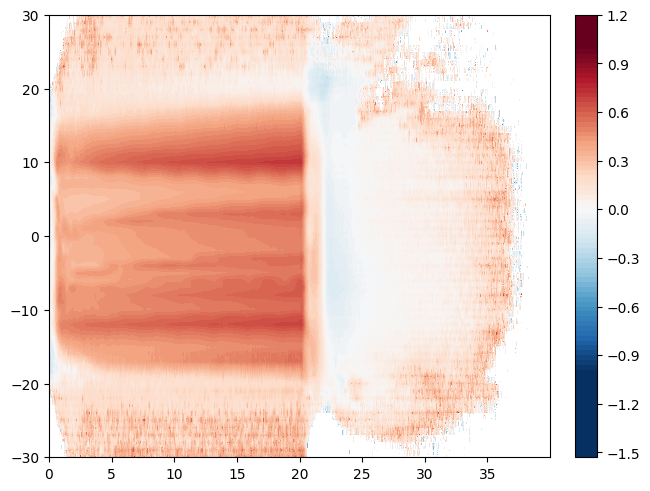

In [20]:
run_num = "21"
puff = "90"
run_name = f"{data_path}{file_dict[run_num]}"
run = SISRun(run_name)
run.config_drive("fixed", run.num_shots, 1, 1, 1)
run.config_drive("xline", 10, nx = 61)
run.rename_channel("b1_c8", "V_anode")
run.rename_channel("b4_c5", "LT")
run.rename_channel("b4_c6", "LB")
run.rename_channel("b4_c7", "RT")
run.rename_channel("b4_c8", "RB")
run.set_drive_props("V_anode", "fixed")
run.set_drive_props("LT", "xline")
run.set_drive_props("LB", "xline")
run.set_drive_props("RT", "xline")
run.set_drive_props("RB", "xline")
run.set_chan_props("V_anode", gain = 1/40)
run.set_chan_props("LT", gain = 0.88, resistance = 7.5)
run.set_chan_props("LB", gain = 1.08, resistance = 7.5) 
run.set_chan_props("RT", gain = 0.86, resistance = 7.5)
run.set_chan_props("RB", gain = 0.94, resistance = 7.5)
t_array = run.board_props["board_4"].time_array
tips = ["LT", "LB", "RT", "RB"]
dt = run.extract_signal("LT").dt
isat_mach = np.empty((4, 610, 249856))
for i, tip in enumerate(tips):
    isat_mach[i] = run.extract_signal(tip)
    isat_mach[i] = np.moveaxis(np.moveaxis(isat_mach[i], 0, 1) - np.mean(isat_mach[i,:,-2000:], axis=-1),0,1)
freq = (1/dt).to(u.Hz).value
# isat_mach = butt_low(isat_mach, 10e3, freq)
# isat_mach_smooth = sav_smooth(isat_mach, b = 60, axis=-1)
mach_front = np.mean(isat_mach[0:2], axis = 0)
mach_back = c*np.mean(isat_mach[2:], axis = 0)
mach_num = np.mean(np.log(mach_front/mach_back).reshape(61,10,249856), axis = 1)/1.66
Y  = (np.arange(61)-30)
X = t_array*1e3
Z = mach_num
fig, ax = plt.subplots(layout = "constrained")
CS = ax.contourf(X, Y, Z, 101, cmap = "RdBu_r", vmin=-1, vmax=1)
cbar = fig.colorbar(CS)
fig.savefig(f"./analysisj23/plots/mach_p20_{puff}V_contour.pdf")
np.savez(f"./analysisj23/mach_p20_{puff}V.npz", time_ms = X, x_pos = Y, mach_num = Z)